Use a simple toy CNN to infer properties of one massive subhalo.

In [11]:
import sys, os
sys.path.append('../')

# Do not use Theano version of lensing gradient
os.environ["DIFF"] = "0"

import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import Planck15
from scipy.integrate import quad
from units import *
from tqdm import *
from lensing_sim import LensingSim
import tensorflow as tf

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Grid size
nx, ny = 28, 28

# 1. Test image generation

Lensing system containing a single massive subhalo.

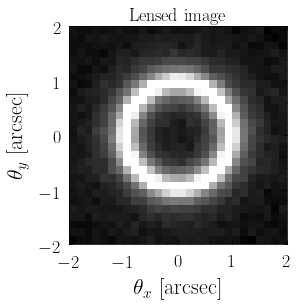

In [6]:
# Host and substructure parameters
hst_param_dict = {'profile':'sis', 'theta_x':0.01, 'theta_y':-0.02, 'theta_E':1.0}
# sub_param_dict = {'profile':'nfw', 'theta_x':-1.01, 'theta_y':-0.01, 'M200':10**13.0*M_s}

# Source parameters
src_param_dict = {'profile':'sersic', 'I_gal':1e-17*erg/Centimeter**2/Sec/Angstrom,'theta_e_gal':0.5,'n_srsc':4}

# Observational parameters
observation_dict = {'nx':nx, 'ny':ny, 'xlims':[-2, 2], 'ylims':[-2, 2], 'exposure':(1/1.8e-19)*erg**-1*Centimeter**2*Angstrom*1000*Sec, 'A_iso':2e-7*erg/Centimeter**2/Sec/Angstrom/(radtoasc)**2, 'z_s':1.0, 'z_l':0.2}
global_dict = {'z_s':1.0, 'z_l':0.2}

# Generate lensed image
LSI = LensingSim([hst_param_dict], [src_param_dict], global_dict, observation_dict)

i_tot = np.random.poisson(LSI.lensed_image())

plt.imshow(np.log10(i_tot), vmax=3.5, cmap = 'gist_gray', extent=LSI.xlims+LSI.ylims)
plt.xlabel("$\\theta_x$ [arcsec]");
plt.ylabel("$\\theta_y$ [arcsec]");
plt.title('Lensed image');

# 2. Generate samples

Generate lens image samples, fixing host halo properties while varying the subhalo pass and it's position on the Einstein ring of the host halo (most sensitive region of the lens system).

In [18]:
N_samp_train = 50000
N_samp_test = 50000

In [31]:
N_samp = N_samp_train + N_samp_test

Y_E = np.ones(N_samp)*1 #np.random.uniform(0.5, 1.5, N_samp)
Y_x = np.ones(N_samp)*0.01 #np.random.uniform(-0.04, 0.04, N_samp)
Y_y = np.ones(N_samp)*0.01 #np.random.uniform(-0.04, 0.04, N_samp)

# Pick substructure position to always lie at Einstein radius for now
Y_sub_x = np.ones(N_samp)*1 #np.random.uniform(0, Y_E, N_samp)
Y_sub_y = np.sqrt(Y_E**2 - Y_sub_x**2)
Y_sub_logM = np.random.uniform(0, 0.3, N_samp)

Y = np.transpose([Y_sub_logM])
# Y = np.transpose([Y_x, Y_y, Y_E, Y_sub_x, Y_sub_logM])

X = np.zeros((N_samp, nx*ny))

LSI = LensingSim(sources_list=[src_param_dict], global_dict=global_dict, observation_dict=observation_dict)

for isamp in tqdm(range(N_samp)):
    hst_param_dict = {'profile':'sis','theta_x':Y_x[isamp], 'theta_y':Y_y[isamp], 'theta_E':Y_E[isamp]}
    sub_param_dict = {'profile':'sis','theta_x':Y_sub_x[isamp], 'theta_y':Y_sub_y[isamp], 'theta_E':Y_sub_logM[isamp]}
    
    LSI.lenses_list = [hst_param_dict, sub_param_dict]
    X[isamp] = np.random.poisson(LSI.lensed_image().flatten())

100%|██████████| 100000/100000 [01:08<00:00, 1458.80it/s]


# 3. Build and train a toy CNN

In [35]:
def cnn_model_fn(features, labels, mode):
    """Model function for CNN."""
    
    # Input Layer
    input_layer = tf.reshape(features["x"], [-1, nx, ny, 1])

    # Convolutional Layer #1
    conv1 = tf.layers.conv2d(
      inputs=input_layer,
      filters=32,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)

    # Pooling Layer #1
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

    # Convolutional Layer #2 and Pooling Layer #2
    conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=64,
      kernel_size=[3, 3],
      padding="same",
      activation=tf.nn.relu)
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

    # Dense Layer
    pool2_flat = tf.reshape(pool2, [-1, int(nx/4 * ny/4) * 64])
    dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
    dropout = tf.layers.dropout(
    inputs=dense, rate=0.25, training=mode == tf.estimator.ModeKeys.TRAIN)
    
    # Logits Layer
    logits = tf.layers.dense(inputs=dropout, units=1)

    # Prediction Function
    # Just the output of the logits layers
    predictions = logits#[:,0]
    
    # If PREDICT, just return the prediction outputs
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    # Calculate Loss (for both TRAIN and EVAL modes)
    loss = tf.losses.mean_squared_error(labels=labels, predictions=predictions)

    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(
        loss=loss,
        global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
      "mse": tf.metrics.mean_squared_error(
          labels=labels, predictions=predictions)}
    
    return tf.estimator.EstimatorSpec(
      mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [36]:
# Create the Estimator
macro_classifier = tf.estimator.Estimator(
    model_fn=cnn_model_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/state/partition1/job-14904941/tmpf1w37cz8', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x2ac83f286e10>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [37]:
# Train the model
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": X[:N_samp_train]},
    y=Y[:N_samp_train],
    batch_size=200,
    num_epochs=None,
    shuffle=True)
 
macro_classifier.train(
    input_fn=train_input_fn,
    steps=1000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /state/partition1/job-14904941/tmpf1w37cz8/model.ckpt.
INFO:tensorflow:loss = 553657.4, step = 1
INFO:tensorflow:global_step/sec: 6.56275
INFO:tensorflow:loss = 1038.7483, step = 101 (15.242 sec)
INFO:tensorflow:global_step/sec: 6.60505
INFO:tensorflow:loss = 820.9816, step = 201 (15.138 sec)
INFO:tensorflow:global_step/sec: 6.61258
INFO:tensorflow:loss = 666.72375, step = 301 (15.122 sec)
INFO:tensorflow:global_step/sec: 6.6999
INFO:tensorflow:loss = 643.35144, step = 401 (14.926 sec)
INFO:tensorflow:global_step/sec: 6.70255
INFO:tensorflow:loss = 466.85034, step = 501 (14.920 sec)
INFO:tensorflow:global_step/sec: 6.65401
INFO:tensorflow:loss = 273.1501, step = 601 (15.029 sec)
INFO:tensorflow:global_step/s

# 4. Predict on test sample 

### and plot true vs predicted subhalo mass.

In [38]:
test_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": X[N_samp_train:N_samp_train + N_samp_test]}, shuffle=False)
preds = np.array([list(macro_classifier.predict(input_fn=test_input_fn))])         

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /state/partition1/job-14904941/tmpf1w37cz8/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


Text(0, 0.5, 'log10(Predicted subhalo mass / M$_\\odot$)')

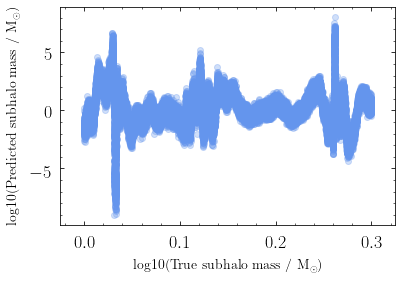

In [39]:
plt.scatter(Y_sub_logM[N_samp_train:N_samp_train + N_samp_test],preds[0,:,-1], alpha=0.3);
# plt.plot(np.linspace(7,14),np.linspace(7,14), ls='--', c='k')
# plt.xlim(9,14)
# plt.ylim(9,14)

plt.xlabel("log10(True subhalo mass / M$_\odot$)", fontsize=14)
plt.ylabel("log10(Predicted subhalo mass / M$_\odot$)", fontsize=14)